最佳角度为：34.0


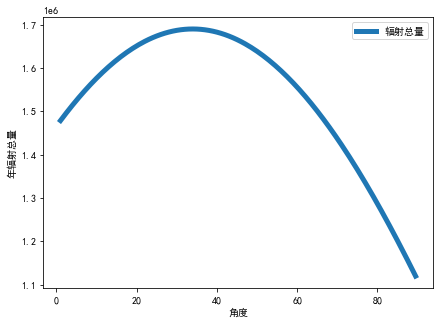

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

data = pd.read_excel('weather_data.xls', sheet_name='逐时气象参数',
                     index_col=0, header=0)
data = data.values

# 水平面总辐射强度
H = data[:, 2]

# 水平面散射辐射强度
Hd = data[:, 3]

# 水平面直射辐射强度
Hb = H - Hd

# 太阳时
hour = data[:, 1]

# 大同市维度
phi = 40.1 / 360 * 2 * np.pi

# 地表反射率
rou = 0.08

# 太阳常数
Isc = 1367

# 太阳修正系数
f = 1 + 0.034 * np.cos(0.9863 * (hour // 24 + 1 - 5))


# 赤纬角
def delta(hour_):
    d = 23.45 * np.sin((2 * np.pi * (284 + hour_ // 24 + 1)) / 365)
    d = d / 360 * 2 * np.pi
    return d


# 斜面日落时角
def ws_wh(delta_, s):
    wh_ = np.arccos(-np.tan(phi) * np.tan(delta_))
    ws_ = np.arccos(-np.tan(phi - s) * np.tan(delta_))
    return np.minimum(wh_, ws_), wh_


# 水平辐射强度与斜面辐强度之比
def Rb(s, delta_=None, ws_=None, wh_=None):
    a = np.cos(phi - s) * np.cos(delta_) * np.sin(ws_) + \
        ws_ * np.sin(phi - s) * np.sin(delta_)
    b = np.cos(phi) * np.cos(delta_) * np.sin(wh_) + \
        wh_ * np.sin(phi) * np.sin(delta_)
    return a / b


delta = delta(hour)


# 计算辐射总量
def calculate(s):
    ws, wh = ws_wh(delta, s)
    Rb_ = Rb(s, delta_=delta, ws_=ws, wh_=wh)
    Ho = 24 / np.pi * f * Isc * (np.cos(phi) * np.cos(delta) * np.sin(wh) +
                                 wh * np.sin(phi) * np.sin(delta))
    Hbt = Hb * Rb_
    Hdt = Hd * (Hb / Ho * Rb_ + 0.5 * (1 - Hb / Ho) * (1 + np.cos(s)))
    Hrt = 0.5 * rou * H * (1 - np.cos(s))
    Ht = Hbt + Hdt + Hrt
    return Ht


angle_list = []
sumht = []
plt.rcParams['font.sans-serif'] = ['SimHei']
for a in np.arange(1, 90, 0.5):
    angle_list.append(a)
    s = a / 360 * 2 * np.pi
    sumht.append(np.sum(calculate(s)))
print('最佳角度为：{}'.format(angle_list[int(np.argmax(sumht))]))
plt.figure(figsize=(7, 5))
plt.plot(angle_list, sumht, linewidth=5, label='辐射总量')
plt.xlabel('角度')
plt.ylabel('年辐射总量')
plt.savefig('最佳角度')
plt.legend()
plt.show()

In [14]:
max_ht = calculate(34 / 360 * 2 * np.pi)
list_ht = []
for i in np.arange(0, len(max_ht), 24):
    list_ht.append(max_ht[i:i+24])
list_ht = np.array([list_ht])
list_ht = np.average(list_ht, axis=1)
for i in range(24):
    print('{}时刻辐射强度平均值：{} W/㎡'.format(i, list_ht[0][i]))

0时刻辐射强度平均值：0.0 W/㎡
1时刻辐射强度平均值：0.0 W/㎡
2时刻辐射强度平均值：0.0 W/㎡
3时刻辐射强度平均值：0.0 W/㎡
4时刻辐射强度平均值：0.0 W/㎡
5时刻辐射强度平均值：0.22405438168928846 W/㎡
6时刻辐射强度平均值：15.262641630515994 W/㎡
7时刻辐射强度平均值：65.56403505818281 W/㎡
8时刻辐射强度平均值：170.82426933341645 W/㎡
9时刻辐射强度平均值：326.40874001193134 W/㎡
10时刻辐射强度平均值：490.0772312624453 W/㎡
11时刻辐射强度平均值：601.2674522760177 W/㎡
12时刻辐射强度平均值：656.2142709867903 W/㎡
13时刻辐射强度平均值：658.8521809369379 W/㎡
14时刻辐射强度平均值：588.4310425011237 W/㎡
15时刻辐射强度平均值：475.629658200374 W/㎡
16时刻辐射强度平均值：330.9677134067867 W/㎡
17时刻辐射强度平均值：172.34277237955214 W/㎡
18时刻辐射强度平均值：64.83737948841136 W/㎡
19时刻辐射强度平均值：13.645480975416303 W/㎡
20时刻辐射强度平均值：0.14751266205322053 W/㎡
21时刻辐射强度平均值：0.0 W/㎡
22时刻辐射强度平均值：0.0 W/㎡
23时刻辐射强度平均值：0.0 W/㎡


插值后最大辐射时刻为：12.600000000000001


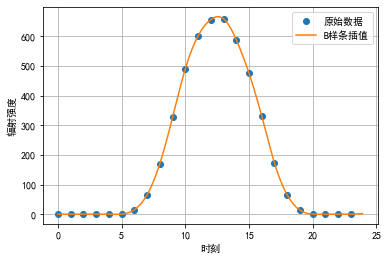

In [33]:
x = np.arange(0, 24, 1)
y = list_ht[0]

x_new = np.arange(0, 24, 0.1)
tck = interpolate.splrep(x, y)
y_bspline = interpolate.splev(x_new, tck)
max_time = x_new[np.argmax(y_bspline)]
print('插值后最大辐射时刻为：{}'.format(max_time))
plt.xlabel(u'时刻')
plt.ylabel(u'辐射强度')

plt.grid()
plt.plot(x, y, "o",  label=u"原始数据")
plt.plot(x_new, y_bspline, label=u"B样条插值")
plt.legend()
plt.savefig('插值.png')
plt.show()

In [35]:
class Battery:
    def __init__(self, name, power, l, w, eta, price):
        self.name = name
        self.power = power
        self.length = l
        self.width = w
        self.s = l * w / 1e6
        self.eta = eta
        self.price = price
        self.cost = None
        self.profit = None


# 所有电池参数
batteries = {'A1': Battery('A1', 215, 1580, 808, 0.1684, 14.9),
             'A2': Battery('A2', 325, 1956, 991, 0.1664, 14.9),
             'A3': Battery('A3', 200, 1580, 808, 0.1870, 14.9),
             'A4': Battery('A4', 270, 1651, 992, 0.1650, 14.9),
             'A5': Battery('A5', 245, 1650, 991, 0.1498, 14.9),
             'A6': Battery('A6', 295, 1956, 991, 0.1511, 14.9),
             'B1': Battery('B1', 265, 1650, 991, 0.1621, 12.5),
             'B2': Battery('B2', 320, 1956, 991, 0.1639, 12.5),
             'B3': Battery('B3', 210, 1482, 992, 0.1598, 12.5),
             'B4': Battery('B4', 240, 1640, 992, 0.1480, 12.5),
             'B5': Battery('B5', 280, 1956, 992, 0.1598, 12.5),
             'B6': Battery('B6', 295, 1956, 992, 0.1520, 12.5),
             'B7': Battery('B7', 250, 1668, 1000, 0.1499, 12.5),
             'C1': Battery('C1', 100, 1300, 1100, 0.0699, 4.8),
             'C2': Battery('C2', 58, 1321, 711, 0.0617, 4.8),
             'C3': Battery('C3', 100, 1414, 1114, 0.0635, 4.8),
             'C4': Battery('C4', 90, 1400, 1100, 0.0584, 4.8),
             'C5': Battery('C5', 100, 1400, 1100, 0.0649, 4.8),
             'C6': Battery('C6', 4, 355, 310, 0.0363, 4.8),
             'C7': Battery('C7', 4, 615, 180, 0.0363, 4.8),
             'C8': Battery('C8', 8, 615, 355, 0.0366, 4.8),
             'C9': Battery('C9', 12, 920, 355, 0.0366, 4.8),
             'C10': Battery('C10', 12, 818, 355, 0.0413, 4.8),
             'C11': Battery('C11', 50, 1645, 712, 0.0427, 4.8)}

for b in batteries.items():
    b[1].cost = (b[1].power * b[1].price) / (b[1].length * b[1].width * 1e-6)

def battery_sort(data_, dict_):
    p = 0.5
    rank_names = []
    rank_profits = []
    rank_gets = []
    rank_cost = []
    for ba in dict_.items():
        if ba[1].price == 4.8:
            mat1 = data_ >= 30
            mat1 = mat1.astype(np.int)
            energy = np.sum(mat1 * data_)
        else:
            mat1 = data_ >= 80
            mat1 = mat1.astype(np.int)
            energy = np.sum(mat1 * data_)
        power = energy * ba[1].eta
        E = power * (10 + 0.9 * 15 + 0.8 + 10)
        zs = E / 1e3 * p
        profit = zs - ba[1].cost
        rank_names.append(ba[1].name)
        rank_profits.append(profit)
        rank_gets.append(zs)
        rank_cost.append(ba[1].cost)
    rank_data = pd.DataFrame(data=rank_names, columns=['电池类型'])
    rank_cost = pd.Series(rank_cost, name='单位面积成本')
    rank_gets = pd.Series(rank_gets, name='单位面积收益')
    rank_profits = pd.Series(rank_profits, name='单位面积利润')
    rank_data = pd.concat([rank_data, rank_cost, rank_gets, rank_profits], axis=1)
    rank_data = rank_data.sort_values('单位面积利润', ascending=False)
    return rank_data

cant_sort = battery_sort(max_ht, batteries)
writer = pd.ExcelWriter('改变倾斜角后屋顶电池利润.xlsx')
cant_sort.to_excel(writer, sheet_name='屋顶电池利润排序')
writer.save()
writer.close()

In [37]:
battery_list = []
def laying_roof(length, width, sort_list):
    if length <= 0 or width <= 0:
        return 0
    else:
        for bat in sort_list:
            if batteries[bat].profit <= 0:
                continue
            if length - batteries[bat].length >= 0 and width - batteries[bat].width >= 0:
                battery_list.append(batteries[bat].name)
                h_h = batteries[bat].profit * batteries[bat].s + \
                      laying_roof(length - batteries[bat].length, batteries[bat].width, sort_list) + \
                      laying_roof(length, width - batteries[bat].width, sort_list)
                h_s = batteries[bat].profit * batteries[bat].s + \
                      laying_roof(batteries[bat].length, width - batteries[bat].width, sort_list) + \
                      laying_roof(length - batteries[bat].length, width, sort_list)
                return max(h_h, h_s)
            elif length - batteries[bat].width >= 0 and width - batteries[bat].length >= 0:
                battery_list.append(batteries[bat].name)
                s_s = batteries[bat].profit * batteries[bat].s + \
                      laying_roof(batteries[bat].width, width - batteries[bat].length, sort_list) + \
                      laying_roof(length - batteries[bat].width, width, sort_list)
                s_h = batteries[bat].profit * batteries[bat].s + \
                      laying_roof(length - batteries[bat].width, batteries[bat].length, sort_list) + \
                      laying_roof(length, width - batteries[bat].length, sort_list)
                return max(s_s, s_h)
        return 0

cant_sort = cant_sort.values[:, [0, -1]]

# 南屋顶
roof_l = 10100
roof_w = 8836
for p in cant_sort:
    batteries[p[0]].profit = p[1]
cant_sort = cant_sort[:, 0]
print('架空后，屋顶最大利润：{}，及此时可用电池板'.format(laying_roof(roof_l, roof_w, cant_sort)))
for i in set(battery_list):
    print(i)
print('\n')
battery_list.clear()


架空后，屋顶最大利润：243256.79213961266，及此时可用电池板
C10
C7
C2
C8
A3
C6




8564.147434377728
